### Natural Language Processing and Sentiment Analysis for Support Desk Comment Review


### Student Names: Trang Nguyen,Hassaan Saleh,Surya Srirangarajan,Kathy Thompson,Jing Zhu


# Install Packages and Libraries

In [129]:
!pip install wordcloud

In [130]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [131]:
!pip install spacy

In [132]:
!pip3 install vpython

In [133]:
import vpython

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [135]:
#Import libraries
import pandas as pd   # for importing & transforming data
import numpy as np # an essential python module
import re   # for regular expressions
import seaborn as sn    # for charts
import seaborn as sns    # for charts
import matplotlib.pyplot as plt   # for wordclouds & charts
import nltk
import nltk.corpus
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
import itertools
from io import StringIO  # python3 (or BytesIO for python2)
import boto3

In [136]:
import seaborn as sns

In [137]:
import plotly.express as px

In [259]:
from IPython.display import clear_output

In [138]:
# Import NLTK Library
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 1. Data Loading and Exploratory Analysis

In [316]:
# Read file from S3 Bucket
data_file = 's3://daen690-goodfellas-data/GMU_CSD_Data1.csv'
df_alldata = pd.read_csv(data_file)
# Perform some preminalry analysis
print('Number of instances = %d' % (df_alldata.shape[0]))
print('Number of attributes = %d' % (df_alldata.shape[1]))
df_alldata.head(20)

# 2. Data Cleaning and Transformation

In [317]:
# Only take selected columns
df_clean = df_alldata[['Unnamed: 0','Instance','Question','String Value','Created']]
df_clean.shape


In [262]:
df_clean.head()


In [319]:
# Tranpose values of 'Question' column into seperate columns. This removes duplicate Instance. 
df_clean = df_clean.pivot(index = ('Instance','Created'), columns = 'Question', values = 'String Value')
df_clean.reset_index(inplace = True)
df_clean.head(20)
df_clean['Issue Resolved'].value_counts()


In [321]:
df_clean.head()

# 3. Breaking Created into Year, Month and Quarter

In [265]:
# Creating new columns for Year, Month and Quarter from existing columnn 'Created'
df_clean['year'] = pd.DatetimeIndex(df_clean['Created']).year
df_clean['Month'] = pd.DatetimeIndex(df_clean['Created']).month
df_clean['quarter'] = pd.to_datetime(df_clean['Created']).dt.quarter
df_clean.shape


In [268]:
df_clean


# 4. Adding sentiment score against likert scale fields

In [146]:
# Create a new dataframe called df_likscale with three new columns. The columns contain the assinged score against
# each sentiment
df_likscale = df_clean
df_likscale['Agent Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Agent Satisfaction']]

df_likscale['Mngmt Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Management Satisfaction']]

df_likscale['Time Sat Score'] = [1 if x == 'Very Satisfied' else 0.5 if x=='Satisfied' else 0 if x=='Neutral' 
                          else -0.5 if x=='Dissatisfied' else -1 if x=='Very Dissatisfied'
                          else 'NaN' for x in df_clean['Time Satisfaction']]






In [269]:
df_likscale.head()


# 5. Creating new Dataframes for each comment type

In [322]:
# Create a new dataframe based on feedback column 
df_feedback = df_clean[['Instance','Feedback']]
# Create a new dataframe based on management comment column 
df_management = df_clean[['Instance','Management Comment']]
# Create a new dataframe based on Unresolved comment column 
df_unresolved = df_clean[['Instance','Unresolved Comment']]
# Remove null values from the three dataframes
df_feedback = df_feedback.dropna()
df_management = df_management.dropna()
df_unresolved = df_unresolved.dropna()
# Create a blank lists to be used in removing whitespace enteries
blank_fdbk = []  
blank_mgmt = []
blank_unres = []
#Remove whitespace entries in feedback comments
df_feedback = df_feedback.dropna()
for i,x,rv in df_feedback.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            blank_fdbk.append(i)     

df_feedback.drop(blank_fdbk, inplace=True)

#Remove whitespace entries in management comments
for i,x,rv in df_management.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            bblank_mgmt.append(i)     

df_management.drop(blank_mgmt, inplace=True)

#Remove whitespace entries in unresolved comments
for i,x,rv in df_unresolved.itertuples():  
    if type(rv)==str:            
        if rv.isspace():  
            blank_unres.append(i)     

df_unresolved.drop(blank_unres, inplace=True)




# 6. Creating Validation Datasets and Reading the Groundthruth Results

In [363]:
# Export subset of comment dataframes into CSVs to use as input for Validation set 

bucket = 'sagemaker-us-east-1-237961066627'   # already created on S3

# # Export management comments dataframe to a CSV

csv_buffer = StringIO()
df_management.to_json(csv_buffer)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'management_comments_json.csv').put(Body=csv_buffer.getvalue())


#####********* Below code is for exporting feedback and unresolved comments to Amazon Ground Truth. The code is
#####********* commented because its incomplete. Can be incorporated in future.

# # Export unresolved comments dataframe to a CSV

# csv_buffer2 = StringIO()
# n = 20
# unresolved_training = df_unresolved.head(int(len(df_unresolved)*(20/100)))  # Export 20% of rows from unresolved comments dataframe to a CSV for training
# unresolved_training.to_json(csv_buffer2)

# s3_resource = boto3.resource('s3')
# s3_resource.Object(bucket, 'subset_unresolved_comments_json.csv').put(Body=csv_buffer2.getvalue())

#--
# # Export all rows from unresolved comments dataframe to a CSV for training
# csv_buffer2 = StringIO()
# df_unresolved.to_json(csv_buffer2)

# s3_resource = boto3.resource('s3')
# s3_resource.Object(bucket, 'full_unresolved_comments_json.csv').put(Body=csv_buffer2.getvalue())
#--

# # Export feedback comments dataframe to a CSV

# csv_buffer3 = StringIO()
# n = 20
# feedback_training = df_feedback.head(int(len(df_feedback)*(n/100))) # Export 20% of rows from feedback comments dataframe to a CSV for training
# feedback_training.to_json(csv_buffer3)

# s3_resource3 = boto3.resource('s3')
# s3_resource3.Object(bucket, 'subset_feedback_comments_json.csv').put(Body=csv_buffer3.getvalue())


# Export all rows from feedback comments dataframe to a CSV for training
# csv_buffer3 = StringIO()
# df_feedback.to_json(csv_buffer3)
# s3_resource3 = boto3.resource('s3')
# s3_resource3.Object(bucket, 'full_feedback_comments_json.csv').put(Body=csv_buffer3.getvalue())


{'ResponseMetadata': {'RequestId': 'A2F74NFDPNPV8V52',
  'HostId': 'KnxQRPY2r9PyVUESo1ZtLF6mHVkpJAaMPxf7RENJqILfVIwnhXguNsFLgg8xqViO+q30RU578Ak=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'KnxQRPY2r9PyVUESo1ZtLF6mHVkpJAaMPxf7RENJqILfVIwnhXguNsFLgg8xqViO+q30RU578Ak=',
   'x-amz-request-id': 'A2F74NFDPNPV8V52',
   'date': 'Sun, 02 May 2021 23:51:50 GMT',
   'etag': '"b42d3f3026867081bb5f9980ab18856b"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"b42d3f3026867081bb5f9980ab18856b"'}

In [364]:
# Reading in labeled results from Ground Truth (S3 bucket)

labeled_mgt = pd.read_json('s3://goodfellas-instance/Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3/manifests/output/output.manifest', lines = True)
#labeled_mgt.head()
labeled_mgt.rename(columns = {"Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3-metadata": "metadata"}, 
          inplace = True)
labeled_mgt.head(20)

# 0: positive
# 1: neutral
# 2: negative

labeled_mgt = labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'].value_counts().reset_index()

#labeled_mgt.head()
# Counts 
#pos: 35 (11%);   
#neu: 81 (26%)   
#neg: 201 (63%)

#type(labeled_mgt)
#labeled_mgt_neu = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 1,:]
#labeled_mgt_neu = labeled_mgt.query("Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3.str.contains(1)")
#labeled_mgt[labeled_mgt['metadata'].str.contains('Negative', na=False)]
#labeled_mgt_neu.head(20)

#labeled_mgt_neg = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 2,:]
#labeled_mgt_neg.head(20)


# labeled_mgt_pos = labeled_mgt.loc[labeled_mgt['Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3'] == 0,:]
# labeled_mgt_pos.head(20)


# reading in labeled unresolved  manifest file
# reading in labeled feedback manifest file


In [365]:
# Assign postive, negative and neutral labels to index numbers
labeled_mgt.loc[labeled_mgt['index'] == 0,['index']]='pos'
labeled_mgt.loc[labeled_mgt['index'] == 1,['index']]='neu'
labeled_mgt.loc[labeled_mgt['index'] == 2,['index']]='neg'

In [366]:
# Sort the dataframe on index
labeled_mgt.sort_values(by=['index'], ascending=True)


In [367]:
# Rename the dataframe columns
labeled_mgt= labeled_mgt.rename(columns = {"index":"Sentiment"})
labeled_mgt= labeled_mgt.rename(columns = {"Support-Desk-Comment-Sentiment-Classification-Mgt-Comments-v3":"Labelled Count"})
labeled_mgt.head()


# 7. Apply VADER on Unresolved, Feedback and Management Comments 

In [324]:
# Using VADER SentimentIntensityAnalyzer() get the polarity score for each comment

analyzer = SentimentIntensityAnalyzer()
# For Unresolved comments
df_unresolved['Score'] = df_unresolved['Unresolved Comment'].apply(lambda review: analyzer.polarity_scores(review))
# For Feedback comments
df_feedback['Score'] = df_feedback['Feedback'].apply(lambda review: analyzer.polarity_scores(review))
# For Management comments
df_management['Score'] = df_management['Management Comment'].apply(lambda review: analyzer.polarity_scores(review))


In [325]:
# Get the compound score based on polarity scores
# For Negative comments
df_unresolved['compound']  = df_unresolved['Score'].apply(lambda score_dict: score_dict['compound'])
# For Feedback commments
df_feedback['compound']  = df_feedback['Score'].apply(lambda score_dict: score_dict['compound'])
# For Management Comments
df_management['compound']  = df_management['Score'].apply(lambda score_dict: score_dict['compound'])

In [344]:
##### Classify the sentiment 
#df_unresolved['Sentiment'] = df_unresolved['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_unresolved['Sentiment'] = df_unresolved['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))
# Feedback comments
#df_feedback['Sentiment'] = df_feedback['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_feedback['Sentiment'] = df_feedback['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))
# Management commments
#df_management['Sentiment'] = df_management['compound'].apply(lambda c: 'pos' if c >0.25 else ('neu' if c <=0.25 and c >= - 0.25 else 'neg'))
df_management['Sentiment'] = df_management['compound'].apply(lambda c: 'pos' if c >0.55 else ('neu' if c <=0.55 and c >= 0.4 else 'neg'))

df_unresolved_count = df_unresolved['Sentiment'].value_counts().reset_index()
df_unresolved_count # pos: 694; neu: 254; neg: 1833

df_feedback_count = df_feedback['Sentiment'].value_counts().reset_index()
df_feedback_count # pos: 3,258; neu: 936; neg: 1727

df_mng_count = df_management['Sentiment'].value_counts().reset_index()
#df_mng_count # pos: 49; neu: 31; neg: 182





# 8. Analyzing the Vader Results and Comparison with Manually Labelled Comments

In [346]:
df_unresolved_comment = pd.concat([df_unresolved, df_unresolved['Score'].apply(pd.Series)], axis = 1).drop('Score', axis = 1)
df_unresolved_comment.head()


df_feedback_comment = pd.concat([df_feedback, df_feedback['Score'].apply(pd.Series)], axis = 1).drop('Score', axis = 1)
df_feedback_comment.head()

# show top 25 highest scoring positive comments
df_feedback_comment.sort_values(by=['pos'], ascending=False).head(25)


# show top 25 highest scoring negative comments
df_feedback_comment.sort_values(by=['neg'], ascending=False).head(25)


df_feedback_comment[df_feedback_comment['Feedback'].str.len() > 85]


pd.set_option('max_colwidth', None)
df_feedback_comment[df_feedback_comment['Feedback'].str.contains('amazing')]




In [347]:
# Create Seperate data frame for positive comments
df_unresolved_pos_comments = df_unresolved[df_unresolved['Sentiment']=='pos']
# Create seperate data frame for neutral comments
df_unresolved_neu_comments = df_unresolved[df_unresolved['Sentiment']=='neu']
# Create seperate data frame for negative comments
df_unresolved_neg_comments = df_unresolved[df_unresolved['Sentiment']=='neg']
#df_unresolved_neg_comments.head()


In [348]:
# Checking total counts for neg,pos and neu comments for Management comments
df_mng_count.head()


In [349]:
# Checking total counts for neg,pos and neu comments for Feedback comments
df_feedback_count.head()


In [350]:
# Checking total counts for neg,pos and neu comments for Unresolved comments
df_unresolved_count.head()


In [351]:
# Sort the Management Comments count dataframe by index
df_mng_count.sort_values(by=['index'], ascending=True)


In [352]:
# Rename the Management Comments count dataframe columns
df_mng_count= df_mng_count.rename(columns = {"Sentiment":"Vader Count"})
df_mng_count= df_mng_count.rename(columns = {"index":"Sentiment"})
df_mng_count.head()


In [369]:
# joining data frames labeled_mgt and df_mng_count to show comparison between Vader and Manually labeled comments
# Here were are only comparing management comments since we only did Ground Truth labelling for management comments
df_mng_comb = labeled_mgt.merge(df_mng_count,how = 'inner', on = 'Sentiment')
df_mng_comb.head()


# 9. Combining Unresolved, Feedback and Management Comments into one dataframe 

In [284]:
# Check data for df_unresolved 
df_unresolved.head(20)


In [370]:
# Drop and Rename Columns in Unresolved Comments dataframe
#New_data.head(20)
df_unres_comb = df_unresolved.drop(['Score','compound'],axis = 1)
df_unres_comb = df_unresolved.rename(columns = {"Unresolved Comment":"Comment"})


In [371]:
#Drop and Rename Columns in Management Comments dataframe
df_mang_comb = df_management.drop(['Score','compound'],axis = 1)
df_mang_comb = df_mang_comb.rename(columns = {"Management Comment":"Comment"})
df_mang_comb.shape
df_mang_comb.head()


In [372]:
#Drop and Rename Columns in Feedback Comments dataframe
df_fbck_comb = df_feedback.drop(['Score','compound'],axis = 1)
df_fbck_comb = df_fbck_comb.rename(columns = {"Feedback":"Comment"})
df_fbck_comb.shape


In [373]:
# Union all three comment types into a single data frame
all_comments = pd.concat([df_unres_comb,df_mang_comb,df_fbck_comb])
all_comments.head()
pd.set_option('max_colwidth', None)
all_comments[all_comments['Comment'].str.contains('amazing')]


In [374]:
# Count of sentiment values in all_comments
all_comments_count = all_comments['Sentiment'].value_counts().reset_index()
all_comments_count.head()
# all_comments_count # pos: 4001; neu: 1221; neg: 3742


In [375]:
# count number of users that left comments  #8,044
users = all_comments['Instance'].nunique()
users


In [290]:
# # show top 25 highest scoring negative comments
all_comments.sort_values(by=['compound'], ascending=True).head(25)


In [376]:
# count number of unique IDs for each sentiment  # positive: 3,897, neutral: 1197; negative: 3,296;
unique = all_comments.groupby('Sentiment')['Instance'].nunique()
unique


In [377]:
# # show top 25 highest scoring positive comments
all_comments.sort_values(by=['compound'], ascending=False).head(25)


# 10. Assessing Sentiment by Comment Length 

In [293]:
df_mang_comb.head()

In [378]:
# Get Comment length (by number of charcters)
all_comments['all_comments_length'] = all_comments['Comment'].str.len()
all_comments.head()

In [379]:
# Get correlation coefficient for compound score vs. comment length 
all_comments['compound'].corr(all_comments['all_comments_length'])


In [380]:
# Get correlation coefficient for neg score vs. comment length
df_unresolved_comment['length'] = df_unresolved_comment['Unresolved Comment'].str.len()
df_management['length'] = df_management['Management Comment'].str.len()
df_feedback['length'] = df_feedback['Feedback'].str.len()


In [296]:
all_comments.head()

In [381]:
# Get correlation coefficient for neg score vs. comment length
df_unresolved_comment['neg'].corr(df_unresolved_comment['length'])


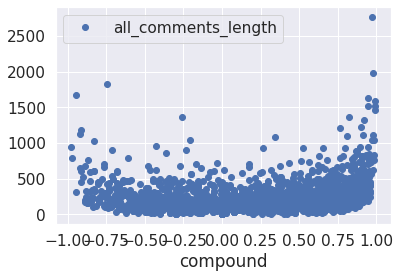

In [298]:
all_comments.plot(x='compound', y='all_comments_length', style='o')
sns.set_theme(color_codes=True)
#ax = sns.regplot(x="compound", y="all_comments_length", data=all_comments)

In [299]:
# get percentiles
all_comments['all_comments_length'].describe()

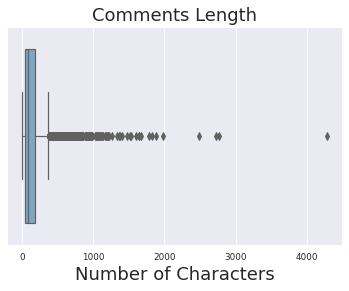

In [300]:
#boxplot of percentiles
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18}) 
boxplot = sns.boxplot(palette = "PuBu", x=all_comments['all_comments_length']).set(title = 'Comments Length', xlabel='Number of Characters')
all_comments['all_comments_length'].describe()

In [301]:
#get average length by sentiment class (see if "negative" comments are longer in length)
all_comments.groupby('Sentiment')['all_comments_length'].mean()
all_comments.groupby('Sentiment')['all_comments_length'].median()

In [302]:
# show comments with length > 500
all_comments[all_comments['Comment'].str.len() > 500]

In [186]:
#getting count of pos, neg, neu by bucket size, to see at what length comments start going from being more positive to more negative

#create length buckets (eg. 50-99, 100-149, 150-199, etc.)
length_sentiment_df = pd.DataFrame(data=all_comments, columns=['all_comments_length', 'Sentiment'])
#bins = np.array([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 5000])

#quartile bins
bins = np.array([0, 41, 85, 172, 4284])

In [303]:
#see where negative count outpaces positive count (if ever)
#CONCLUSION: there is no length where there are more negative comments than positive
#bins = np.array([172, 272, 372, 472, 572, 672, 772, 872, 972, 1072, 1172, 1272, 1372, 1472, 1572])

#test bucket assignments
length_sentiment_df["bucket"] = pd.cut(length_sentiment_df.all_comments_length, bins)
length_sentiment_df.head()

In [304]:
# get count of pos, neg and neu comments within each bucket                             
class_by_length = length_sentiment_df.groupby(['bucket'])['Sentiment'].value_counts()
class_by_length.head()

# 11. Creating Seperate Data Frames for Positive, Neutral and Negative Sentiments 

In [305]:
# Create Seperate data frame for positive comments
all_pos_comments = all_comments[all_comments['Sentiment']=='pos']
all_pos_comments.count() # positive count = 6,041

In [306]:
# Create seperate data frame for neutral comments
all_neu_comments = all_comments[all_comments['Sentiment']=='neu']
all_neu_comments.count() # neutral count = 2,066

In [307]:
# Create seperate data frame for negative comments
all_neg_comments = all_comments[all_comments['Sentiment']=='neg']
all_neg_comments.count() # negative count = 857


# 12. Data visualization

## Wordcloud for all comments combined

In [308]:
all_comments.head()

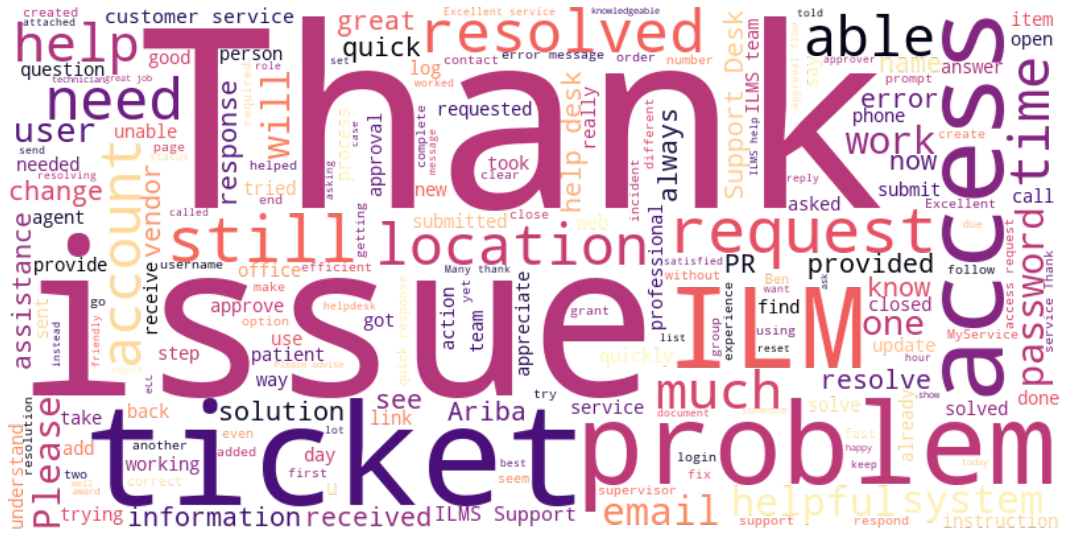

In [314]:
text = " ".join(review for review in all_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## WordClouds for Unresolved, Management and Feedback Comments

In [194]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 155.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(30, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

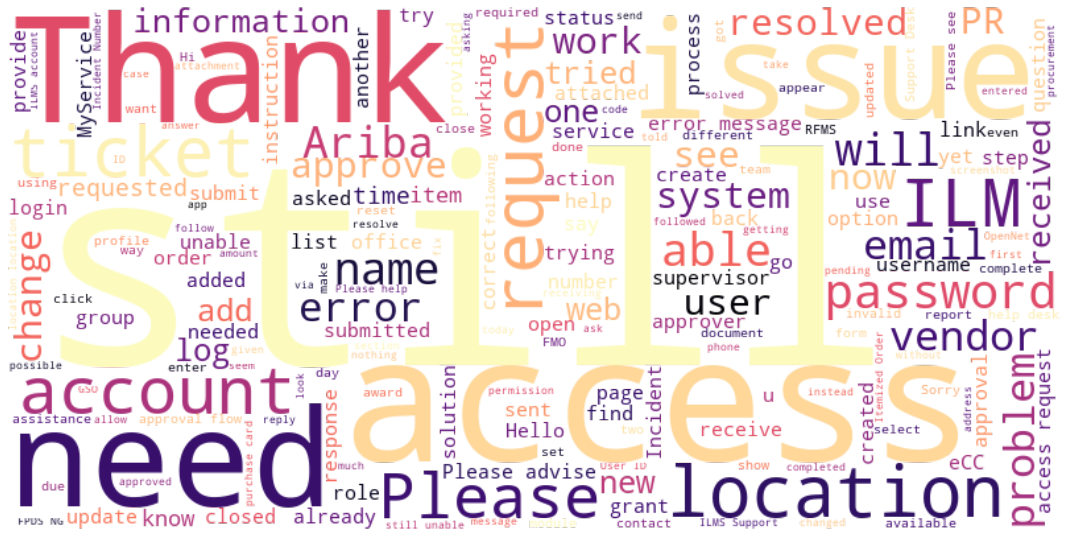

In [195]:
# Word Cloud on Unresolved Comments
from nltk import word_tokenize, sent_tokenize
text = " ".join(review for review in df_unresolved["Unresolved Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.savefig('Unresolved_wordcloud.png', transparent=True)
plt.show()

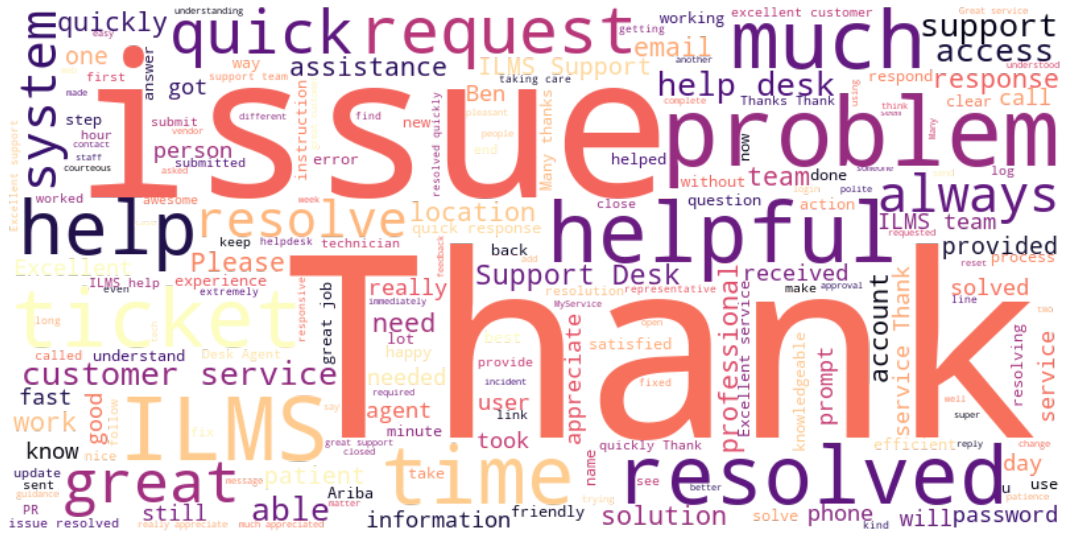

In [196]:
# WordCloud for Feedback: 
text = " ".join(review for review in df_feedback["Feedback"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

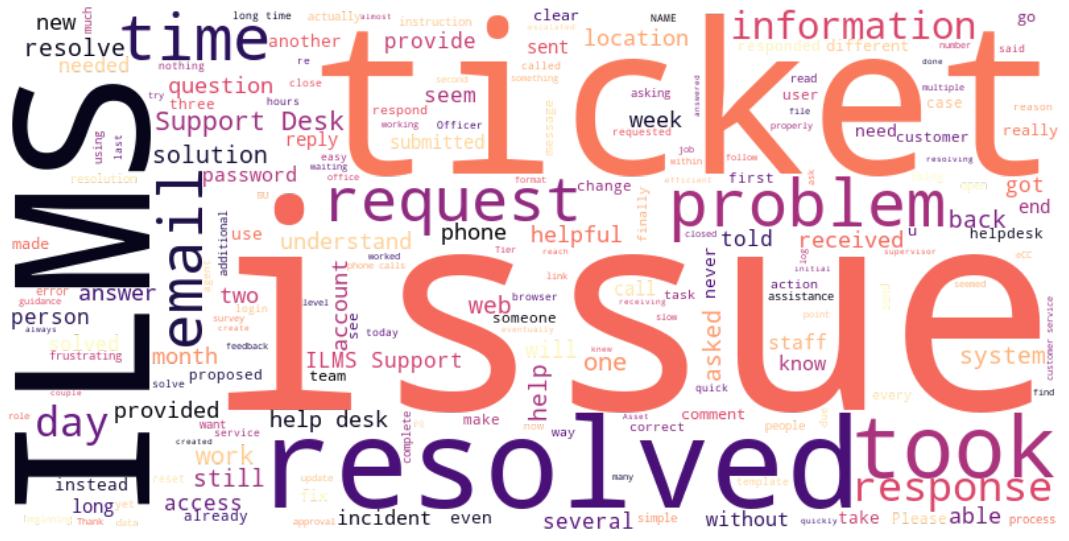

In [197]:
# WordCloud for Management Comments: 
text = " ".join(review for review in df_management["Management Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## Word Cloud for Positive, Neutral and Negative Comments

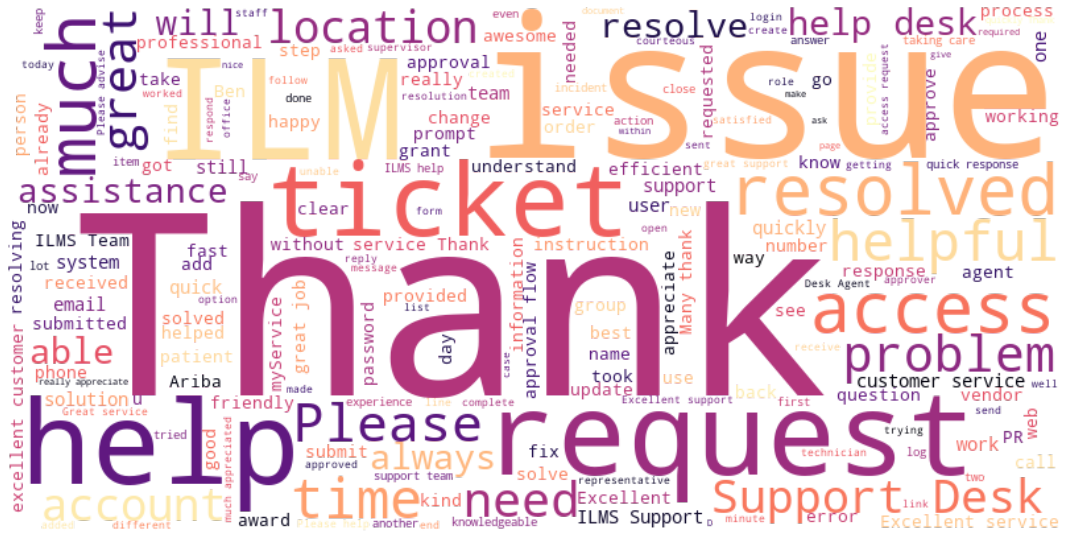

In [198]:
# Word Cloud for Positive Comment
text = " ".join(review for review in all_pos_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

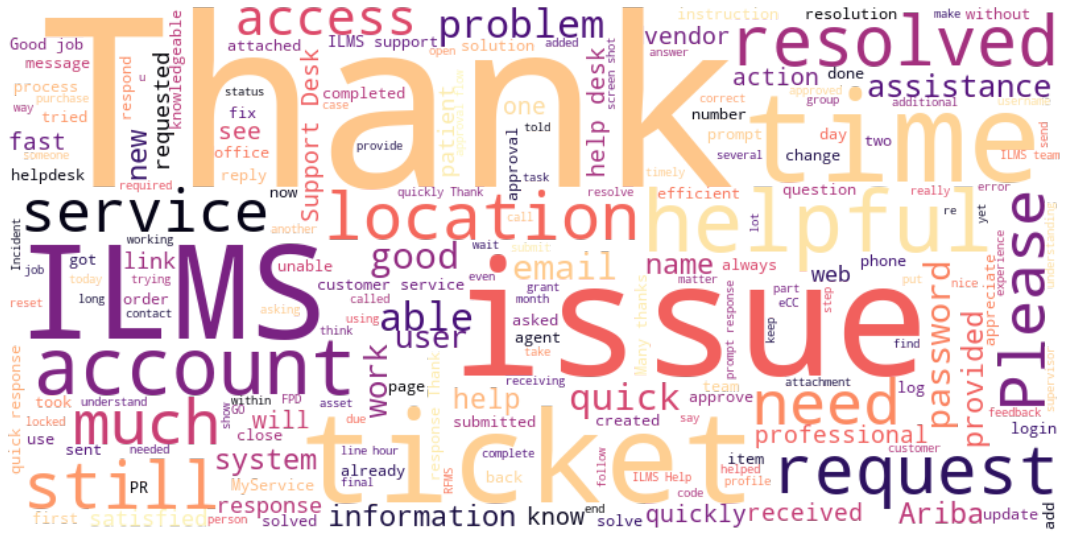

In [199]:
# Word Cloud for Neutral Comment
text = " ".join(review for review in all_neu_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

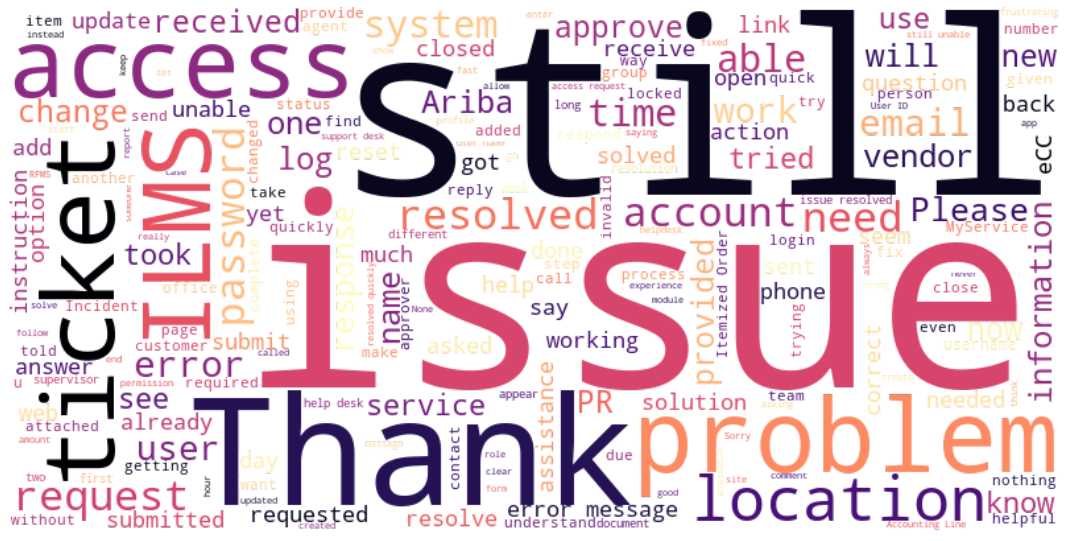

In [200]:
# Word Cloud for Negative Comment
text = " ".join(review for review in all_neg_comments["Comment"].astype(str))
wordcloud = WordCloud(stopwords=STOPWORDS, mode = "RGBA", background_color=None, colormap="magma", width=800, height=400).generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

## Bar Charts for Unresolved, Feedback and Mangement Comments

<AxesSubplot:title={'center':'Detected Sentiment of Management Comments'}>

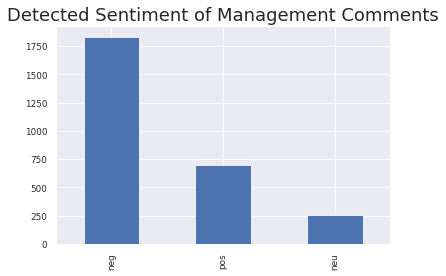

In [201]:

# Barchart showing sentiments for Unresolved Comments
df_unresolved['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Management Comments")

<AxesSubplot:title={'center':'Detected Sentiment of Feedback Comments'}>

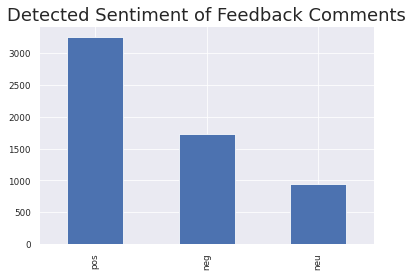

In [202]:
# Barchart showing sentiments for feedback Comments
df_feedback['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Feedback Comments")

<AxesSubplot:title={'center':'Detected Sentiment of Management Comments'}>

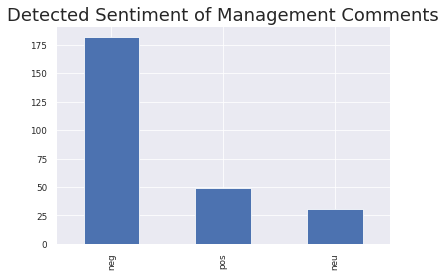

In [203]:
# Barchart showing sentiments for Management Comments
df_management['Sentiment'].value_counts().plot(kind='bar',title="Detected Sentiment of Management Comments")

## Bar Charts by Question Types

<AxesSubplot:title={'center':'Comment Types by Agent Satisfaction'}>

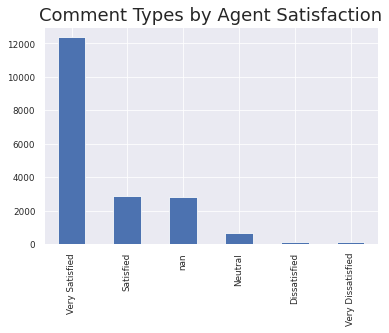

In [204]:
# By Agent Satisfaction
df_agensat = df_alldata.loc[df_alldata['Question']=='Agent Satisfaction',['Question','String Value']]
df_agensat = df_agensat['String Value'].value_counts(dropna = False)
df_agensat.plot(kind = "bar",title = "Comment Types by Agent Satisfaction")


Very Satisfied    12399
Satisfied          2869
NaN                2805
Neutral             628
Dissatisfied        147
Name: String Value, dtype: int64

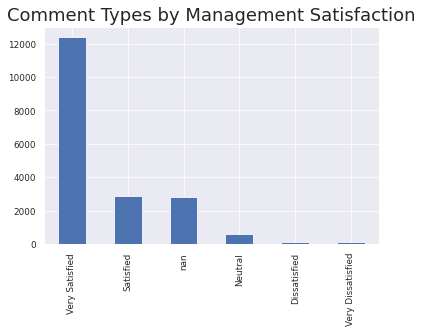

In [205]:
# By Management Satisfaction
df_mngsat = df_alldata.loc[df_alldata['Question']=='Management Satisfaction',['Question','String Value']]
df_mngsat = df_mngsat['String Value'].value_counts(dropna = False)
df_mngsat.plot(kind = "bar",title = "Comment Types by Management Satisfaction")
df_mngsat.head()

<AxesSubplot:title={'center':'Comment Types by Issue Resolved'}>

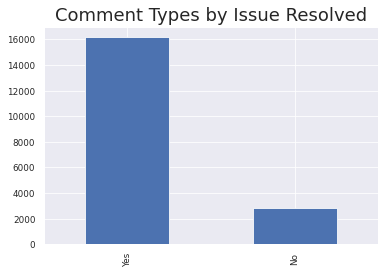

In [206]:
# By Issue Resolved
df_issres = df_alldata.loc[df_alldata['Question']=='Issue Resolved',['Question','String Value']]
df_issres = df_issres['String Value'].value_counts(dropna = False)
df_issres.plot(kind = "bar",title = "Comment Types by Issue Resolved")

## Correlation Plot

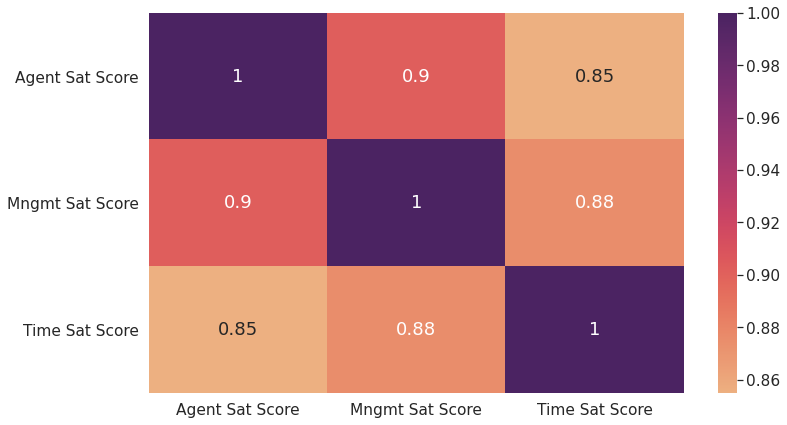

In [207]:
# correlation matrix of Agent Score, Mgmt Score and Time Score
corr_df = pd.DataFrame(df_clean, columns=['Agent Sat Score', 'Mngmt Sat Score', 'Time Sat Score'])
#corr_df = df5[['Agent Sat Score', 'Mngmt Sat Score', 'Time Sat Score']]
corr_df = corr_df.astype(float)
corrMatrix = corr_df.corr()
#print(corrMatrix)
sns.set(font_scale=1.4)
plt.figure(figsize = (12,7))
#sn.heatmap(corrMatrix, cmap=customPalette, annot=True, annot_kws={"size": 18})
sn.heatmap(corrMatrix, cmap="flare", annot=True, annot_kws={"size": 18})
plt.show()

## Quarter Wise Sentiment Analysis

In [220]:
df_timeanalysis = all_comments.merge(df_clean,how = 'inner', on = 'Instance')
df_quarter = df_timeanalysis.loc[df_timeanalysis['year']==2020,]
df_quarter = df_timeanalysis[['quarter','Sentiment']]
df_quarter= df_quarter.groupby(['quarter','Sentiment']).size().reset_index(name = 'Count')
df_quarter.head()

,quarter,Sentiment,Count
0,1,neg,1013
1,1,neu,322
2,1,pos,1023
3,2,neg,593
4,2,neu,271


In [221]:
df_quarter = df_quarter.groupby(['quarter','Sentiment']).size().reset_index(name = 'Count')

In [222]:
import plotly.express as px
fig = px.bar(df_quarter, x="quarter", y="Count", color="Sentiment", title="Long-Form Input")
fig.show()

## Month Wise Sentiment Analysis

In [223]:

df_timeanalysis['Month'] = df_timeanalysis['Month'].astype(str)
df_timeanalysis['Month']=df_timeanalysis.Month.str.pad(2,side='left',fillchar='0')
df_timeanalysis = df_timeanalysis.sort_values(by = 'Month')


In [224]:
import calendar

#df_timeanalysis['Month'] = df_timeanalysis['Month'].apply(lambda x: calendar.month_abbr[x])
df_timeanalysis['YearMonth'] = df_timeanalysis['year'].astype(str) + ' ' + df_timeanalysis['Month'].astype(str) 
df_timeanalysis = df_timeanalysis[['YearMonth','Sentiment']]
df_timeanalysis = df_timeanalysis.groupby(['YearMonth','Sentiment']).size().reset_index(name = 'Count')
df_timeanalysis.sort_values(by = 'YearMonth')
df_timeanalysis.head(20)

,YearMonth,Sentiment,Count
0,2019 10,neg,320
1,2019 10,neu,70
2,2019 10,pos,208
3,2019 11,neg,318
4,2019 11,neu,73
5,2019 11,pos,177
6,2019 12,neg,285
7,2019 12,neu,75
8,2019 12,pos,228
9,2020 01,neg,334


In [254]:
import plotly.express as px
import plotly.graph_objs as go

#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=px.colors.qualitative.Vivid)
#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=["DarkBlue", "DarkCyan", "DarkMagenta"])
#fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=px.colors.qualitative.Vivid, template="simple_white")
fig = px.line(df_timeanalysis, x='YearMonth', y='Count', color='Sentiment', color_discrete_sequence=["#00003d","#8e008b" ,"#ff8300"])
fig.update_layout(xaxis = go.layout.XAxis(tickangle = 45), 
        font=dict(
        family="Arial, monospace",
        size=16,
        color="black"
    ))

fig.show()
# color schemes: https://plotly.com/python/discrete-color/
# https://www.w3schools.com/cssref/css_colors.asp


In [234]:
fig.write_html("FIGURE.html")  # Save to HTML

# DASH server - DONT NEED THIS FOR NOW

In [215]:
pip install jupyter-dash #Dont need this for now

Note: you may need to restart the kernel to use updated packages.


In [216]:

from jupyter_dash import JupyterDash

#JupyterDash.infer_jupyter_proxy_config()

In [217]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import pandas as pd


external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children = [
    dcc.Graph(id = "line-graph",
             figure =fig
             )
])


if __name__ == '__main__':
    app.run_server()

Dash app running on http://127.0.0.1:8050/


In [218]:
app.run_server(mode="jupyterlab")

# Common word pairings (bigrams, trigrams) 

In [219]:
#word pairings for unresolved comments

#unresolved_comments_tokenized = nltk.word_tokenize(New_data)
#nltk.download('punkt')

# unresolved_comments_tokenized = df5['Unresolved Comment'].apply(word_tokenize)
# unresolved_comments_bigrams = nltk.bigrams(unresolved_comments_tokenized)

# #compute frequency distribution for all the bigrams in the text
# fdist = nltk.FreqDist(unresolved_comments_bigrams)
# for k,v in fdist.items():
#     print(k,v)
    

# TF-IDF Vectorizer 

Below is the code for TF-IDF Vectorizer. The code still need some tweaks to work in a proper manner. Can be used as a reference for future developments

In [97]:
# Train on first 800 comments, then test on all 2771 comments

In [98]:

# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')

In [99]:
# tf_train = New_data['Unresolved Comment'][0:800]

In [100]:
# tf_train = df_unresolved[0:800]

In [101]:
# tf_test = df_unresolved

In [102]:
# tfidfvectorizer = TfidfVectorizer(analyzer='word' , stop_words='english',)

In [103]:
# tfidfvectorizer.fit(tf_train)

In [104]:
# tfidf_train = tfidfvectorizer.transform(tf_train)

In [105]:
# tfidf_term_vectors = tfidfvectorizer.transform(tf_test)

In [106]:
# tfidf_term_vectors.todense()

In [107]:
# For first 5 Unresolved Comments, print the top 20 TF-IDF scores (separate training and testing) 
#    and the associated word (descending order)
# Comments separated by New Line

# for i in range(5):
#     test_vec = tfidf_term_vectors[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
#     print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
#     print('\n')

In [108]:
# all_comments.head()

In [109]:
# Tests and trains on all the comments at once
#tfidf_test2 = tfidfvectorizer.fit_transform(all_comments['Comment'])

In [110]:
# tfidf_test2.todense()

In [111]:
# tfidf_words_df = pd.DataFrame

In [112]:
# For first 5 Unresolved Comments, print the top 20 TF-IDF scores (train and test at once) 
#   and the associated word (descending order)
# Comments separated by New LineTF-IDF

# for i in range(5):
#     test_vec = tfidf_test2[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
#     print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
#     print('\n')

In [113]:
# tfidf_words_df = test_df.sort_values(by=["tfidf"],ascending=False).reset_index()
# tfidf_words_df = tfidf_words_df.rename(columns = {"index":"Words"})
# #df_unresolved.rename(columns = {"Unresolved Comment":"Comment"})
# tfidf_words_df.head(20)

In [114]:
# df = tfidf_words_df.head()
# fig = px.bar(df, x="tfidf", y= "Words", orientation='h')
# fig.update_layout( yaxis=dict(autorange="reversed"))
# fig.show()

In [115]:
# for i in range(len(all_comments)):
#     test_vec = tfidf_test2[i]
#     test_df = pd.DataFrame(test_vec.T.todense(), 
#                            index = tfidfvectorizer.get_feature_names(), 
#                            columns=["tfidf"])
# #    print(test_df.sort_values(by=["tfidf"],ascending=False)[:20])
# #    print('\n')
#     test_df.sort_values(by=["tfidf"],ascending=False)
    
#     for i in range(3):
#         print(tfidf_words_df['Words'] )
# #= test_df[i]
    

# Top words per cluster

The code still need some tweaks to work in a proper manner. Can be used as a reference for future developments

In [116]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vectorizer = CountVectorizer()

In [117]:
# .fit_transfer TOKENIZES and COUNTS
# X = count_vectorizer.fit_transform(tf_train)

In [118]:
# X.toarray()

In [119]:
# pd.DataFrame(X.toarray())

In [120]:
##What do all of those numbers mean????
# count_vectorizer.get_feature_names()

In [121]:
# from nltk.stem.porter import PorterStemmer
# porter_stemmer = PorterStemmer()

# def stemming_tokenizer(str_input):
#     words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
#     words = [porter_stemmer.stem(word) for word in words]
#     return words

# count_vectorizer = CountVectorizer(stop_words='english', tokenizer=stemming_tokenizer)
# X = count_vectorizer.fit_transform(tf_train)
# print(count_vectorizer.get_feature_names())

In [122]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [123]:
#value = (number of times word appears in sentence) / (number of words in sentence)
# tfidf_vectorizer = TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=False, norm='l1')
# X = tfidf_vectorizer.fit_transform(tf_train)
# df8 = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())
# df8

In [124]:
# KMeans clustering is a method of clustering.
# from sklearn.cluster import KMeans
# number_of_clusters = 2
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)

In [125]:
# vectorizer.get_feature_names()

In [126]:
# Initialize a vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, max_features=2, tokenizer=stemming_tokenizer, stop_words='english')
# X = vectorizer.fit_transform(tf_train)

In [127]:
# df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
# df

In [646]:
# ax = df.plot(kind='scatter', x='pleas', y='thi', alpha=0.1, s=300)
# ax.set_xlabel("pleas")
# ax.set_ylabel("thi")

In [647]:
# results = pd.DataFrame()
# results['text'] = tf_train
# results['category'] = km.labels_
# results

In [648]:
# number_of_clusters = 3
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)
# df8['category'] = km.labels_
# df8

In [649]:
# print("Top terms per cluster:")
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(number_of_clusters):
#     top_ten_words = [terms[ind] for ind in order_centroids[i, :5]]
#     print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

In [650]:
# color_list = ['r', 'b', 'g', 'y']
# colors = [color_list[i] for i in df['category']]

# ax = df.plot(kind='scatter', x='pleas', y='thi', alpha=0.1, s=300, c=colors)
# ax.set_xlabel("pleas")
# ax.set_ylabel("thi")

In [651]:
# # Initialize a vectorizer
# vectorizer = TfidfVectorizer(use_idf=True, max_features=3, tokenizer=stemming_tokenizer, stop_words='english')
# X = vectorizer.fit_transform(tf_train)

In [652]:
# vectorizer.get_feature_names()

In [653]:
# df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
# df

In [654]:
# from sklearn.cluster import KMeans

# number_of_clusters = 4
# km = KMeans(n_clusters=number_of_clusters)
# km.fit(X)
# df['category'] = km.labels_

In [655]:
# df['text'] = tf_train
# df

In [656]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# def draw(ax, df):
#     color_list = ['r', 'b', 'g', 'y']
#     colors = [color_list[i] for i in df['category']]

#     marker_list = ['o', 'x', 'v', 'X']
#     markers = [marker_list[i] for i in df['category']]

#     ax.scatter(df8['pleas'], df8['thi'], df8['wa'], c=colors, s=100, alpha=0.5)
#     ax.set_xlabel('pleas')
#     ax.set_ylabel('thi')
#     ax.set_zlabel('wa')

# chart_count_vert = 5
# chart_count_horiz = 5
# number_of_graphs = chart_count_vert * chart_count_horiz

# fig = plt.figure(figsize=(3 * chart_count_horiz, 3 * chart_count_vert))

# for i in range(number_of_graphs):
#     ax = fig.add_subplot(chart_count_horiz, chart_count_vert, i + 1, projection='3d', azim=(-360 / number_of_graphs) * i)
#     draw(ax, df8)